In [153]:
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.signal as signal
import numpy as np
import librosa.filters as filter
import yaml
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt


In [154]:
class Model:
    def __init__(self,yaml_path) -> None:
        self.config = self._load_yaml(yaml_path)

    def _load_yaml(self, yaml_path):
        with open(yaml_path, 'r', encoding='utf-8') as file:
            data = yaml.safe_load(file)
        return self._convert_values(data)
    
    def _convert_values(self, data):
        if isinstance(data, dict):
            return {key: self._convert_values(value) for key, value in data.items()}
        elif isinstance(data, list):
            return [self._convert_values(item) for item in data]
        elif isinstance(data, str):
            if data == 'None':
                return None
            if '.' in data:
                try:
                    return float(data)
                except ValueError:
                    return data
            else:
                try:
                    return int(data)
                except ValueError:
                    return data
        elif data is None:
            return 'None'
        return data

In [155]:
model = Model(r'C:/Users/isuis/projects/python/tile/app/yaml/config.yaml')
model.config

{'read': {'api': 'WASAPI',
  'device': 'ライン',
  'input': 2,
  'sample_rate': 48000,
  'dtype': 'int16',
  'block_size': 2048,
  'ch': 0,
  'eu': 0.00061035},
 'buffer': {'time': 0.5},
 'fft': {'n_fft': 2048, 'power': 1},
 'volume': {'num_block': -5.0, 'low': 10, 'mid': 15},
 'trigger': {'pos_1': 0.005,
  'pos_2': 0.1,
  'pos_3': 1,
  'pos_4': 10,
  'non': None,
  'buffer_num': -5.0,
  'hold': 0.05,
  'offset': -1024.0,
  'length': 4096},
 'train': {'num': 30},
 'threshold': {'num': 30},
 'PL_BPF': {'f_min': 1000, 'f_max': 16000, 'g_pass': 3, 'g_stop': 40},
 'PL_FFT': {'n_fft': 4096, 'power': 2},
 'PL_MEL': {'n_mels': 40, 'f_min': 300, 'f_max': 16000}}

In [156]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from scipy import signal

class BandPassFilter(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.b, self.a = self._design_filter()

    def _design_filter(self):
        fn = self.fs / 2
        fp = np.array([self.f_min, self.f_max])
        fs = np.array([self.f_min/2, self.f_max*1.5])
        wp = fp / fn
        ws = fs / fn
        N, Wn = signal.buttord(wp, ws, self.g_pass, self.g_stop)
        b, a = signal.butter(N, Wn, "band")
        return b, a

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self._bandpass(X)
    
    def _bandpass(self, x):
        y = signal.filtfilt(self.b, self.a, x)
        return y

    @property
    def fs(self):
        return self.model.config['read']['sample_rate']
    
    @property
    def f_min(self):
        return self.model.config['PL_BPF']['f_min']

    @property
    def f_max(self):
        return self.model.config['PL_BPF']['f_max']
    
    @property
    def g_pass(self):
        return self.model.config['PL_BPF']['g_pass']
    
    @property
    def g_stop(self):
        return self.model.config['PL_BPF']['g_stop']


In [157]:
class FasrFourierTransform(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self._fft(X)
    
    def _fft(self, x):
        if x.ndim == 1:
            x = x.reshape(1,-1)

        win = np.hanning(x.shape[-1])
        data = x * win
        spec = np.fft.rfft(a=data,
                           n=self.n_fft,
                           norm='forward')[:,:self.f_range]
        spec /= np.mean(win)
        spec = np.abs(spec) ** self.power
        spec[:,1:] *= 2
        return spec

    @property
    def fs(self):
        return self.model.config['read']['sample_rate']
    
    @property
    def n_fft(self):
        return self.model.config['PL_FFT']['n_fft']
    
    @property
    def power(self):
        return self.model.config['PL_FFT']['power']
    
    @property
    def f_range(self):
        return int(self.n_fft/2.56)+1

In [158]:
class Mel(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.melfb = csr_matrix(filter.mel(sr=self.fs,
                                    n_fft=self.n_fft,
                                    n_mels=self.n_mels,
                                    fmin=self.f_min,
                                    fmax=self.f_max,
                                    htk=True,
                                    norm=1)[:,:self.f_range])

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self._mel(X)
    
    def _mel(self, x):
        return self.melfb.dot(x.T).T

    @property
    def fs(self):
        return self.model.config['read']['sample_rate']
    
    @property
    def n_mels(self):
        return self.model.config['PL_MEL']['n_mels']
    
    @property
    def n_fft(self):
        return self.model.config['PL_FFT']['n_fft']
    
    @property
    def f_min(self):
        return self.model.config['PL_MEL']['f_min']

    @property
    def f_max(self):
        return self.model.config['PL_MEL']['f_max']
    
    @property
    def f_range(self):
        return int(self.n_fft/2.56)+1

In [171]:
class ZScore(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._mean = None
        self._std = None

    def fit(self, X, y=None):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        self.std[self.std == 0] = 1e-8


    def transform(self, X):
        z_scores = (X - self.mean) / self.std
        anomaly = np.mean(np.abs(z_scores), axis=1)
        return anomaly
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    
    @property
    def mean(self):
        return self._mean
    
    @mean.setter
    def mean(self, value):
        self._mean = value
        
    @property
    def std(self):
        return self._std
    
    @std.setter
    def std(self, value):
        self._std = value

In [160]:
bpf = BandPassFilter(model)
fft = FasrFourierTransform(model)
mel = Mel(model)
zscore = ZScore()

data = np.random.randn(10,4096)
print(data.shape)

data_bpf = bpf.transform(data)
print(data.shape)

data_fft = fft.transform(data_bpf)
print(data.shape)

data_mel = mel.transform(data_fft)
print(data.shape)

zscore.fit(data_mel)
zscore.std.shape

(10, 4096)
(10, 4096)
(10, 4096)
(10, 4096)


(40,)

# あってるか確かめる

In [161]:
def bandpass(X):
    fn = model.config['read']['sample_rate'] / 2
    fp = np.array([model.config['PL_BPF']['f_min'], model.config['PL_BPF']['f_max']])
    fs = np.array([model.config['PL_BPF']['f_min']/2, model.config['PL_BPF']['f_max']*1.5])
    wp = fp / fn
    ws = fs / fn
    n, wn = signal.buttord(wp, ws, model.config['PL_BPF']['g_pass'], model.config['PL_BPF']['g_stop'])
    b, a = signal.butter(n, wn, 'band')
    y = signal.filtfilt(b, a, X)
    return y

_data_bpf = bandpass(data)

print(np.max(np.abs(data_bpf - _data_bpf)))

0.0


In [162]:
def fft(X):
    if X.ndim == 1:
        X = X.reshape(1,-1)

    win = np.hanning(X.shape[-1])
    data = X * win
    spec = np.fft.rfft(a=data,
                        n=model.config['PL_FFT']['n_fft'],
                        norm='forward')[:,:int(model.config['PL_FFT']['n_fft']/2.56)+1]
    spec /= np.mean(win)
    spec = np.abs(spec) ** model.config['PL_FFT']['power']
    spec[:,1:] *= 2
    return spec

_data_fft = fft(_data_bpf)

print(np.max(np.abs(data_fft - _data_fft)))

0.0


In [163]:
melfb = csr_matrix(filter.mel(sr=model.config['read']['sample_rate'],
                                    n_fft=model.config['PL_FFT']['n_fft'],
                                    n_mels=model.config['PL_MEL']['n_mels'],
                                    fmin=model.config['PL_MEL']['f_min'],
                                    fmax=model.config['PL_MEL']['f_max'],
                                    htk=True,
                                    norm=1)[:,:int(model.config['PL_FFT']['n_fft']/2.56)+1])

def mel(X):
    return melfb.dot(X.T).T

_data_mel = mel(_data_fft)

print(np.max(np.abs(data_mel - _data_mel)))

0.0


In [164]:
_mean = np.mean(_data_mel, axis=0)
_std = np.std(_data_mel, axis=0)

print(np.max(np.abs(zscore.mean - _mean)))
print(np.max(np.abs(zscore.std - _std)))

0.0
0.0


# いい感じ

# 実際にやってみる

In [165]:
def generate_sine_wave(frequency, sample_rate, duration):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    return np.sin(2 * np.pi * frequency * t)

In [187]:
train = np.array([generate_sine_wave(1000, 48000, 4096/48000) for _ in range(10)])
test = np.array([generate_sine_wave(10000, 48000, 4096/48000) for _ in range(10)])

In [188]:
from sklearn.pipeline import Pipeline

In [189]:
pipeline = Pipeline([
    ('bandpass_filter',BandPassFilter(model)),
    ('fft',FasrFourierTransform(model)),
    ('mel',Mel(model)),
    ('anomaly',ZScore()),
])

In [190]:
pipeline.fit(train)
pl_anomaly = pipeline.transform(test)
print(pl_anomaly)

[2.3958054e+21 2.3958054e+21 2.3958054e+21 2.3958054e+21 2.3958054e+21
 2.3958054e+21 2.3958054e+21 2.3958054e+21 2.3958054e+21 2.3958054e+21]


In [191]:
pipeline = Pipeline([
    ('bandpass_filter',BandPassFilter(model)),
    ('fft',FasrFourierTransform(model)),
    ('mel',Mel(model)),
    ])

train_mel = pipeline.transform(train)
test_mel = pipeline.transform(test)

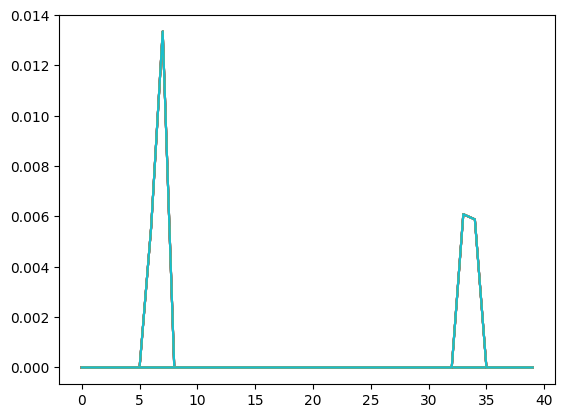

In [192]:
_,ax = plt.subplots()
ax.plot(train_mel.T)
ax.plot(test_mel.T)